In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_loc = "D:/Beam Characterization/2019_2_26/"
fname = "2019_2_26.h5"

In [3]:
with h5py.File(data_loc+fname, 'r') as f:
    print(list(f.values()))

[<HDF5 group "/1551201641 11mJ run1" (1 members)>, <HDF5 group "/1551202323 11mJ run2 same spot" (1 members)>, <HDF5 group "/1551202414 11mJ run3 focus change" (1 members)>, <HDF5 group "/1551203105 11mJ run4 focus change" (1 members)>, <HDF5 group "/1551203284 11mJ run5 focus change" (1 members)>, <HDF5 group "/1551209402 11mJ scan1 new spot" (1 members)>, <HDF5 group "/1551209973 11mJ scan2 new spot" (1 members)>, <HDF5 group "/1551210537 11mJ scan3 new spot" (1 members)>, <HDF5 group "/1551224466 22mJ scan4 new spot" (1 members)>, <HDF5 group "/1551226009 22mJ scan5 new spot" (1 members)>]


In [4]:
run_name = "/1551210537 11mJ scan3 new spot"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['WA1500'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

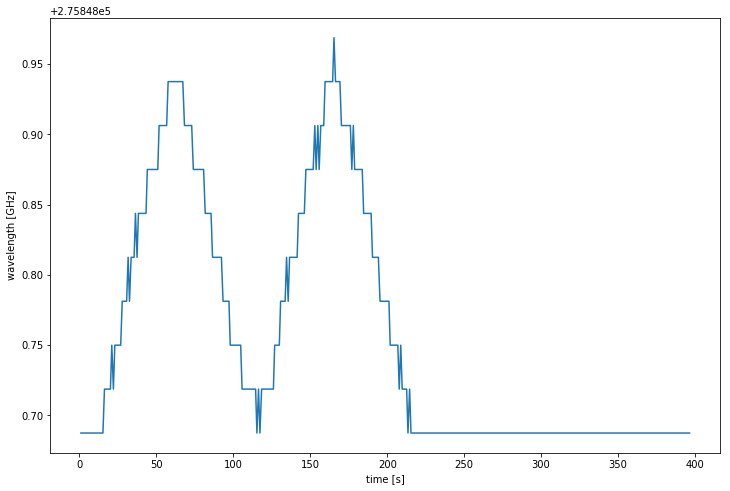

In [5]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavemeter[:,0],wavemeter[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

# Correlation between photodiodes

[2.18797820e-01 9.76204368e+03 5.49145508e-01 2.75472347e-03
 6.44656993e-03]


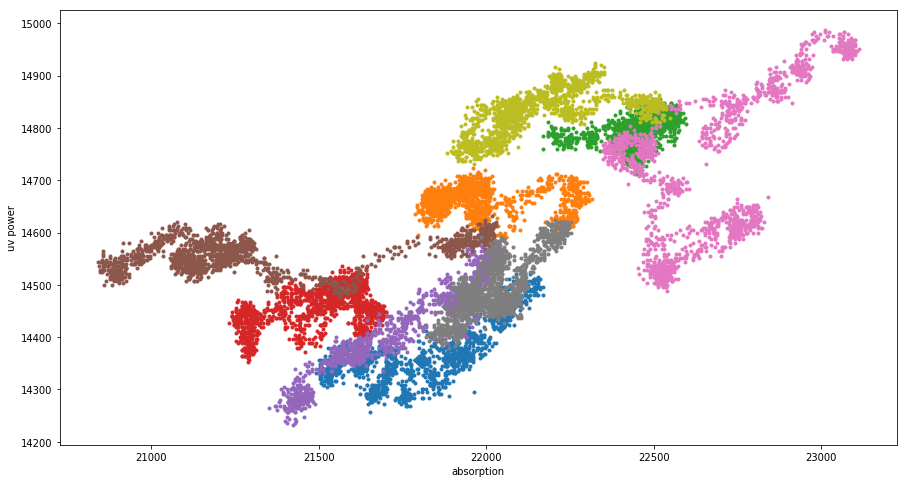

In [6]:
from scipy.stats.stats import pearsonr   
from scipy.stats import linregress

corr_abs_mon = []
fig, ax = plt.subplots(figsize = (15,8))
ax.set_xlabel("absorption")
ax.set_ylabel("uv power")
for i in range(1,10):
    corr_abs_mon.append(linregress(fast_daq['PXIe5171_{0}'.format(i)][:,1],fast_daq['PXIe5171_{0}'.format(i)][:,4]))
    ax.plot(fast_daq['PXIe5171_{0}'.format(i)][:,1],fast_daq['PXIe5171_{0}'.format(i)][:,4], '.')
print(np.mean(corr_abs_mon, axis = 0))

In [7]:
yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]

Manually removing some indices where the lock not functioning properly

In [8]:
yag_fire.remove(121)
yag_fire.remove(119)
yag_fire.remove(120)
yag_fire.remove(122)

## Finding unique wavelength values from the wavemeter

In [9]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [10]:
rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)    

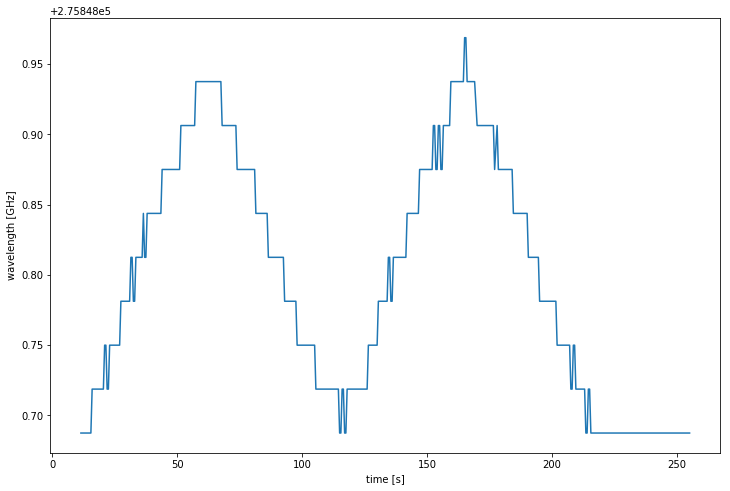

In [11]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavelength_values[:,0]*rate, wavelength_values[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

In [12]:
np.where(np.array(yag_fire) == 122)

(array([], dtype=int64),)

123


Text(0.5, 0, 'time [ms]')

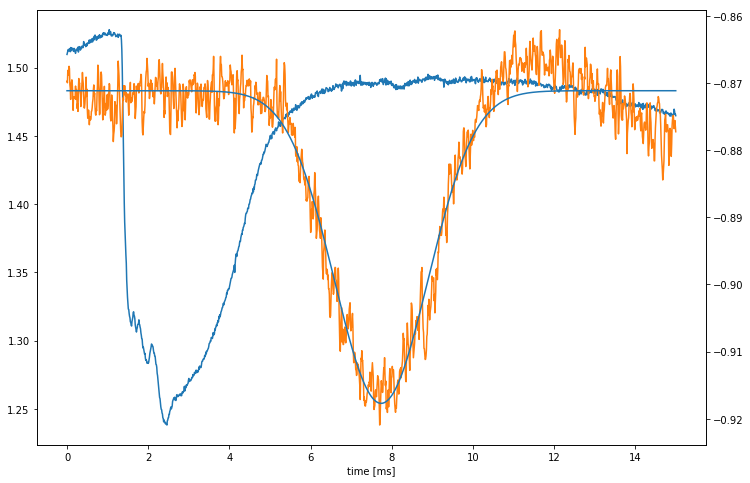

In [13]:
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma, b):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+b

idx = 96
idx = yag_fire[idx]
print(idx)

x = np.linspace(0,1500,1500)/100

data_a = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]

p0 = (-0.2, 8, 1, -1)
bounds = ([-10,5,0,-2],[0,11,4,-0.5])
try:
    fit, pcov = curve_fit(gaus, x, data_f, p0 = p0, bounds = bounds)
except RuntimeError:
    pass

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, data_a)
ax1 = ax.twinx()
ax1.plot(x, data_f, 'C1')
ax1.plot(x, gaus(x, *fit))

ax.set_xlabel("time [ms]")

In [14]:
fits = []
pcovs = []
x = np.linspace(0,1500,1500)/100

for idx in yag_fire:
    data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
    p0 = (-0.2, 8, 1, -1)
    bounds = ([-10,5,0,-2],[0,11,4,-0.5])
    try:
        fit, pcov = curve_fit(gaus, x, data_f, p0 = p0, bounds = bounds)
        fits.append((idx,fit))
    except RuntimeError:
        print(idx)
    pcovs.append((idx,pcov))
fits = dict(fits)

In [15]:
wavelength_amp = []
for idx_f in fits:
    if fits[idx_f][0] < 0:
        wavelength_amp.append((dict(wavelength_values)[idx_f], fits[idx_f][0], idx_f))
wavelength_amp = np.array(wavelength_amp)

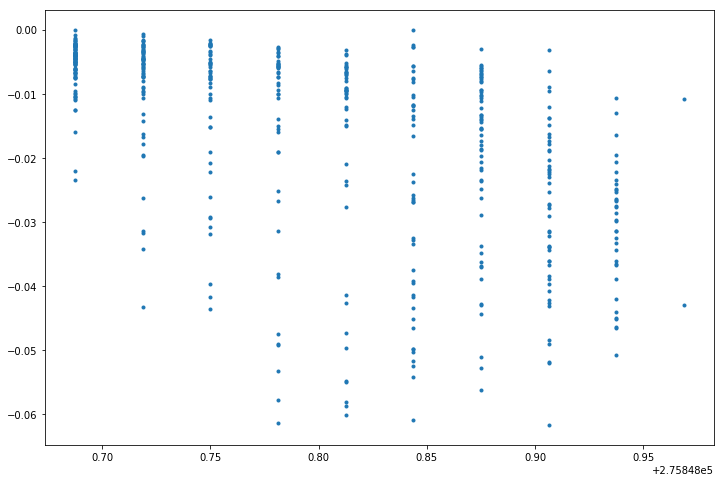

In [16]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavelength_amp[:,0], wavelength_amp[:,1], '.')

Wavemeter is not precise enough to identify transitions! ~30MHz on the wavemeter.

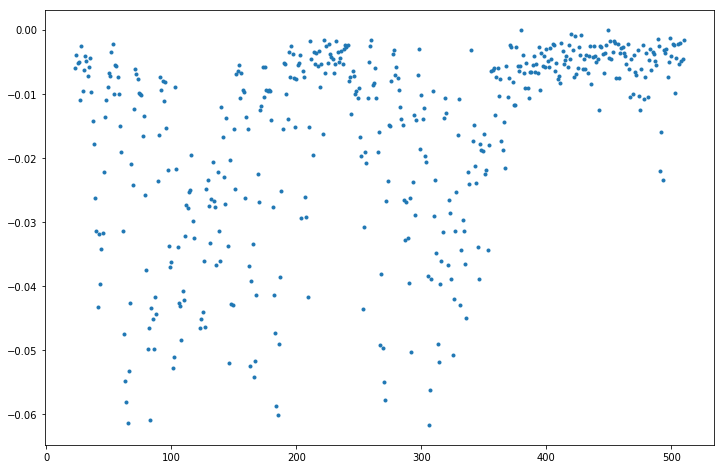

In [17]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavelength_amp[:,2], wavelength_amp[:,1], '.')

# Frequencies from the Cs scanning

In [18]:
import datetime as dt

scan_name = '2019-2-26_scan3.lvm'

with open(data_loc+scan_name, 'r') as f:
    lines = f.read().split('\n')
    date = lines[9]
    time = lines[10]
    start_time = dt.datetime.strptime(date.split(',')[-1]+' '+time.split(',')[-1][:15], "%Y/%m/%d %H:%M:%S.%f")
    values = lines[22:-1]
    frequencies = []
    for val in values:
        a,b = val.split(',')
        t = (start_time+dt.timedelta(seconds = float(a))).timestamp()-fast_start
        frequencies.append((t,float(b)))
    frequencies = np.array(frequencies)

Text(0, 0.5, 'frequency [MHz]')

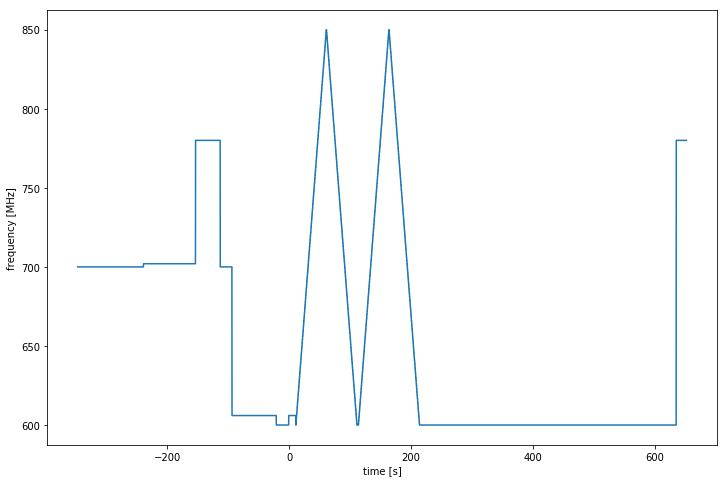

In [19]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequencies[:,0], frequencies[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('frequency [MHz]')

In [20]:
rate = 1/2
frequency_values = []
for idx in yag_fire:
    frequency_values.append((int(idx), frequencies[:,1][find_nearest_idx(frequencies[:,0], idx*rate)]))
frequency_values = np.array(frequency_values)    

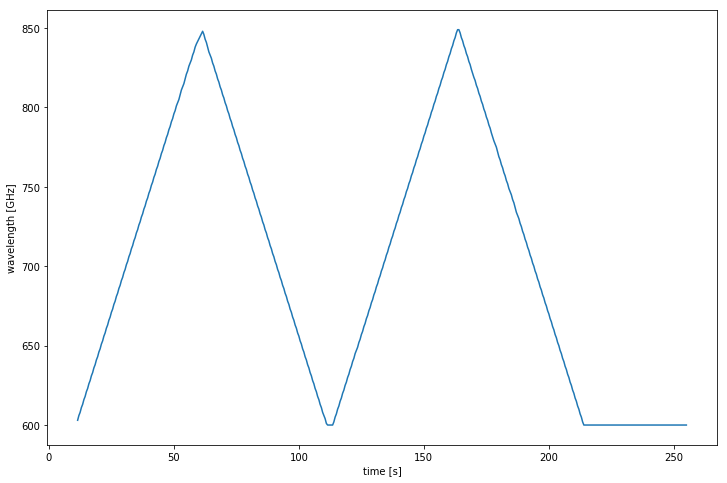

In [21]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_values[:,0]*rate, frequency_values[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

In [22]:
wavelength_values[0,1]

275848.6875

In [23]:
frequency_amp = []
for idx_f in fits:
    if fits[idx_f][0] < 0:
        frequency_amp.append((dict(frequency_values)[idx_f], fits[idx_f][0], idx_f))
frequency_amp = np.array(frequency_amp)
frequency_amp_wavemeter_cal = frequency_amp.copy()
frequency_amp_wavemeter_cal[:,0] += wavelength_values[0,1]*1e3-frequency_amp[0,0]

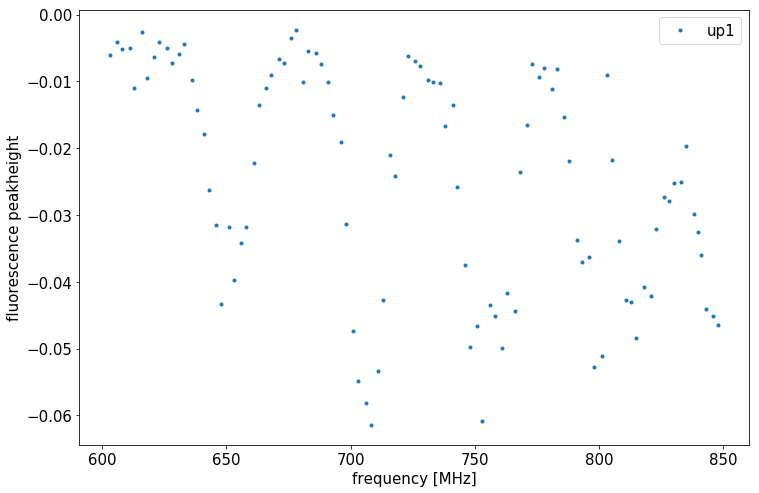

In [24]:
conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_amp[:,0][:100]*conversion, frequency_amp[:,1][:100], '.', label = 'up1')
# ax.plot(frequency_amp[:,0][210:300]*conversion, frequency_amp[:,1][210:300], '.', label = 'up2')
ax.legend(fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

We are writing the set frequency, not the actual current frequency so there is a lag between scanning up and down in our graphs.

# Scan 4 new spot

In [226]:
run_name = "/1551224466 22mJ scan4 new spot"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['WA1500'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

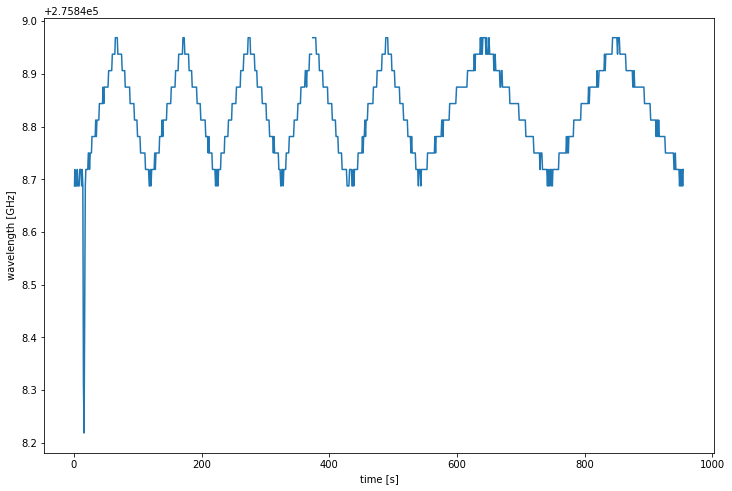

In [227]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavemeter[:,0],wavemeter[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

In [228]:
yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]

In [229]:
rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)    

In [230]:
import tqdm
fits = []
pcovs = []
x = np.linspace(0,1500,1500)/100

for idx in tqdm.tqdm(yag_fire):
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
        p0 = (-0.2, 6, 1, -1)
        bounds = ([-10,4,0,-2],[0,11,4,-0.5])
        try:
            fit, pcov = curve_fit(gaus, x, data_f, p0 = p0, bounds = bounds)
            fits.append((idx,fit))
        except RuntimeError:
            print(idx)
        pcovs.append((idx,pcov))
fits = dict(fits)

100%|██████████████████████████████████████████████████████████████████████████████| 1883/1883 [00:35<00:00, 52.66it/s]


## Frequencies from Cs scanning

In [231]:
def find_nearest_value(set_val, val1, val2):
    if np.abs(set_val-val1) < np.abs(set_val-val2):
        return val1
    else:
        return val2
    return val

In [232]:
import datetime as dt

scan_name = '2019-2-26_scan4.lvm'

with open(data_loc+scan_name, 'r') as f:
    lines = f.read().split('\n')
    date = lines[9]
    time = lines[10]
    start_time = dt.datetime.strptime(date.split(',')[-1]+' '+time.split(',')[-1][:15], "%Y/%m/%d %H:%M:%S.%f")
    values = lines[23:-1]
    frequencies = []
    for val in values:
        a,b,c,d = val.split(',')
        if (float(a) == 0) or (float(a) == 1) or (float(a) == 2) or (float(a) == 3):
            continue
        if b == '':
            continue
        b = float(b)
        try:
            c = float(c)
        except ValueError:
            continue
        d = float(d)
        if np.isnan(d):
            d = 1e5
        if (len(frequencies) > 1):
            if (np.abs(frequencies[-1][1]-b) > 900):
                b += 1000
                c += 1000
                d += 1000
        t = (start_time+dt.timedelta(seconds = float(a))).timestamp()-fast_start
        frequencies.append((t,b,find_nearest_value(b,c,d)))
    frequencies = np.array(frequencies)

In [233]:
rate = 1/2
frequency_values = []
for idx in yag_fire:
    frequency_values.append((int(idx), frequencies[:,1][find_nearest_idx(frequencies[:,0], idx*rate-1.5)]))
frequency_values = np.array(frequency_values)

frequency_amp = []
for idx_f in fits:
    if fits[idx_f][0] < 0:
        frequency_amp.append((dict(frequency_values)[idx_f], np.abs(fits[idx_f][0]), idx_f))
frequency_amp = np.array(frequency_amp)
frequency_amp_wavemeter_cal = frequency_amp.copy()
frequency_amp_wavemeter_cal[:,0] += wavelength_values[0,1]*1e3-frequency_amp[0,0]

In [234]:
mask = frequency_amp[:,0] >= 500
frequency_amp = frequency_amp[mask]
frequency_amp_wavemeter_cal = frequency_amp_wavemeter_cal[mask]

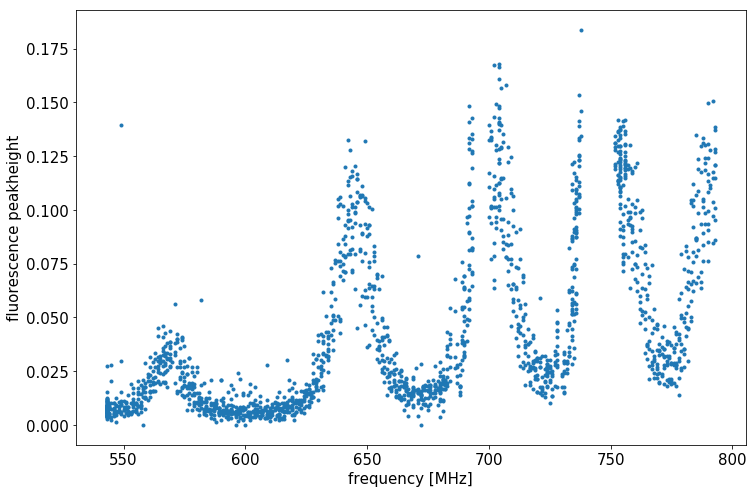

In [235]:
conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_amp[:,0]*conversion, frequency_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

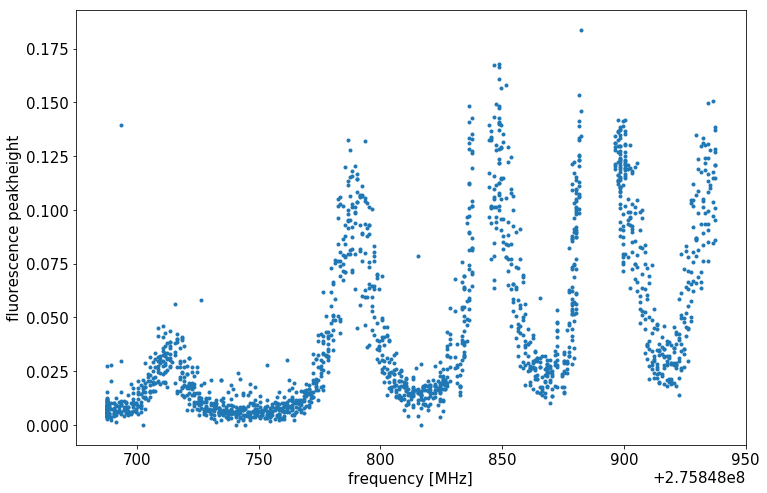

In [236]:
conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_amp_wavemeter_cal[:,0]*conversion, frequency_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);
fig.savefig('scanning.png')

peak 0 : 1103394.852 GHz
peak 1 : 1103395.157 GHz
peak 2 : 1103395.381 GHz
peak 3 : 1103395.568 GHz
peak 4 : 1103395.741 GHz
peak 0-1 : 304.8 MHz
peak 1-2 : 224.1 MHz
peak 2-3 : 187.4 MHz
peak 3-4 : 172.6 MHz


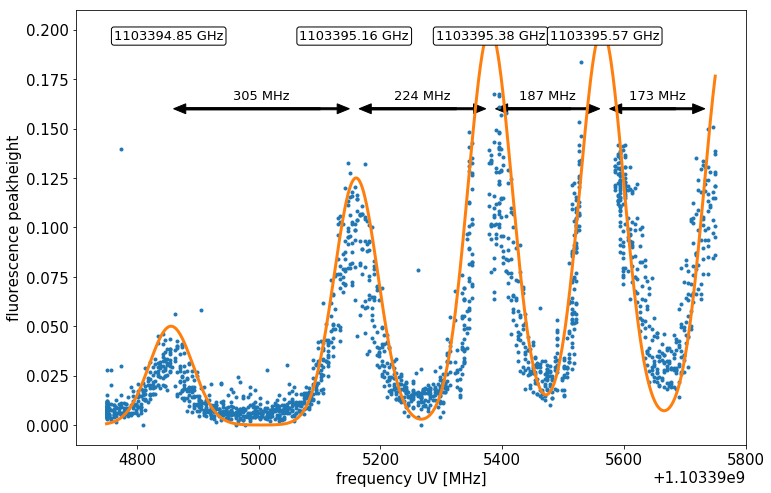

In [331]:
def fit_fun(x,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t):
    return gaus(x,a,b,c,d)+gaus(x,e,f,g,h)+gaus(x,i,j,k,l)+gaus(x,m,n,o,p)+gaus(x,q,r,s,t)
a = 0.05
sigma = 9
offset = 0
p0 = [0.05,2.75848e8+714,sigma,offset,0.125,2.75848e8+790,sigma,offset ,0.2,2.75848e8+845,sigma,offset,0.2, 2.75848e8+891,sigma,offset, 0.2, 2.75848e8+942,sigma,offset]

fit_array = frequency_amp_wavemeter_cal[frequency_amp_wavemeter_cal[:,0].argsort()]
fit_x = np.linspace(fit_array[:,0].min(), fit_array[:,0].max(), 1001)

popt, pcov = curve_fit(fit_fun, fit_array[:,0], fit_array[:,1], p0 = p0)

conversion = 4
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(fit_array[:,0]*conversion, fit_array[:,1], '.')
ax.plot(fit_x*conversion, fit_fun(fit_x, *p0), lw = 3)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency UV [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

for ploc, dist in zip(popt[1::4][:-1], np.diff(popt[1::4])):
    ax.text(conversion*(ploc+dist/2),0.165,'{0:.0f} MHz'.format(dist*conversion), horizontalalignment='center', fontsize = 13)
    ax.text(conversion*(ploc), 0.195, '{0:.2f} GHz'.format(ploc/1e3*conversion), horizontalalignment='center', fontsize = 13, bbox= dict(boxstyle="round", fc="w", ec="k", pad=0.2))
    ax.arrow(conversion*(ploc+7),0.160,conversion*(dist-14),0, shape = 'full', head_width=0.005, head_length=5*conversion, fc='k', ec='k')
    ax.arrow(conversion*(ploc+(dist-14)),0.160,conversion*(-(dist-14-7)),0, shape = 'full', head_width=0.005, head_length=5*conversion, fc='k', ec='k')

for idx, p in enumerate(popt[1::4]):
    print('peak {0} : {1:.3f} GHz'.format(idx, p/1e3*conversion))
for idx, pdiff in enumerate(np.diff(popt[1::4])):
    print('peak {0}-{1} : {2:.1f} MHz'.format(idx, idx+1, pdiff*conversion))
    
    
fig.savefig('scanning_UV.png')

In [238]:
fit_array.shape

(1878, 3)

## Using Scipy to find peaks and LMFIT to fit them

In [240]:
def g(x, A, μ, σ):
    return A / (σ * math.sqrt(2 * math.pi)) * np.exp(-(x-μ)**2 / (2*σ**2))

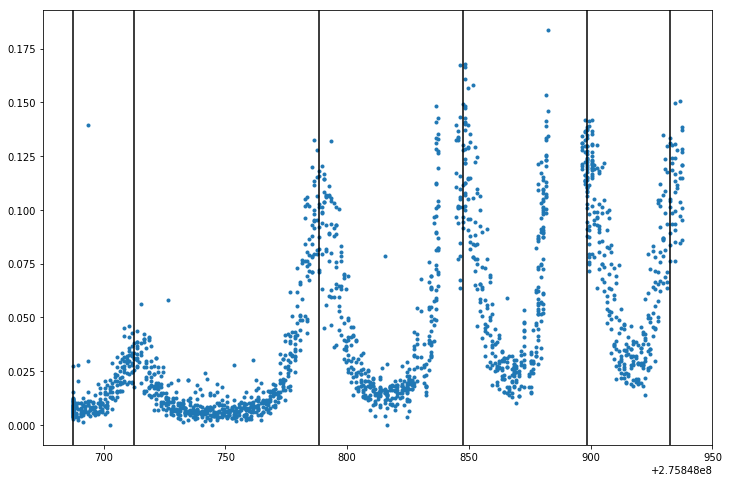

In [262]:
from scipy.signal import find_peaks_cwt
peaks = find_peaks_cwt(fit_array[:,1], [55]*3)
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(fit_array[:,0], fit_array[:,1], '.')
[ax.axvline(fit_array[:,0][idx], color = 'k') for idx in peaks];

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.


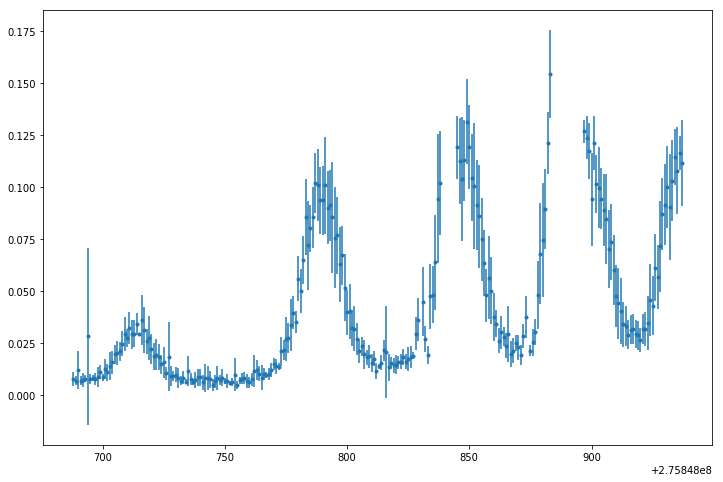

In [319]:
df = 1
f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
bin_indices = np.digitize(fit_array[:,0], f_bins)
bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
midpoint = np.diff(f_bins)/2+f_bins[:-1]

mask_nan = ~np.isnan(bin_means)
bin_means = bin_means[mask_nan]
bin_errors = bin_errors[mask_nan]
midpoint = midpoint[mask_nan]

fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(midpoint, bin_means, yerr = bin_errors, fmt = '.');

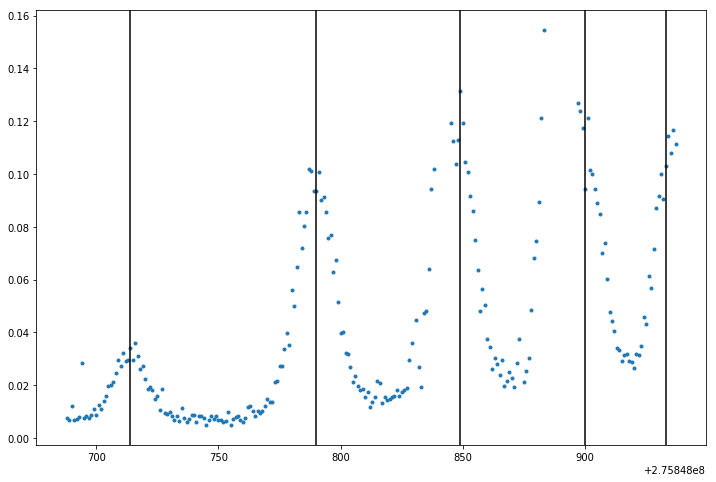

In [321]:
from scipy.signal import find_peaks_cwt
peaks = find_peaks_cwt(bin_means, [7]*3)
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(midpoint, bin_means, '.')
[ax.axvline(midpoint[idx], color = 'k') for idx in peaks];

# Scan 5 new spot

In [337]:
run_name = "/1551226009 22mJ scan5 new spot"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['WA1500'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

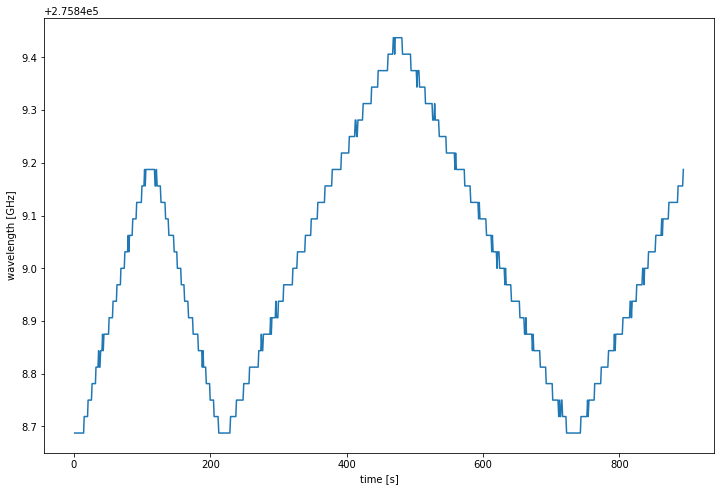

In [338]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavemeter[:,0],wavemeter[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

227


Text(0.5, 0, 'time [ms]')

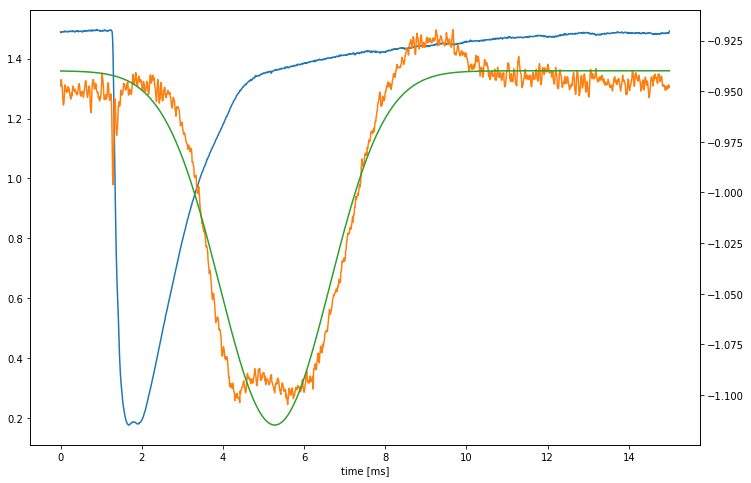

In [339]:
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma, b):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+b

idx = 200
idx = yag_fire[idx]
print(idx)

x = np.linspace(0,1500,1500)/100

data_a = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]

p0 = (-0.2, 6, 1, -1)
bounds = ([-10,4,0,-2],[0,11,4,-0.5])
try:
    fit, pcov = curve_fit(gaus, x, data_f, p0 = p0, bounds = bounds)
except RuntimeError:
    pass

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, data_a)
ax1 = ax.twinx()
ax1.plot(x, data_f, 'C1')
ax1.plot(x, gaus(x, *fit), 'C2')

ax.set_xlabel("time [ms]")

In [340]:
yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]

rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)    

fits = []
pcovs = []
x = np.linspace(0,1500,1500)/100

for idx in tqdm.tqdm(yag_fire):
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]

        p0 = (-0.2, 6, 1, -1)
        bounds = ([-10,4,0,-2],[0,11,4,-0.5])

        try:
            fit, pcov = curve_fit(gaus, x, data_f, p0 = p0, bounds = bounds)
            fits.append((idx,fit))
        except RuntimeError:
            print(idx)
        pcovs.append((idx,pcov))
fits = dict(fits)

100%|██████████████████████████████████████████████████████████████████████████████| 1767/1767 [00:27<00:00, 44.64it/s]


# Frequencies from Cs scanning

In [341]:
def find_nearest_value(set_val, val1, val2):
    if np.abs(set_val-val1) < np.abs(set_val-val2):
        return val1
    else:
        return val2
    return val

In [342]:
import datetime as dt

scan_name = '2019-2-26_scan5.lvm'

with open(data_loc+scan_name, 'r') as f:
    lines = f.read().split('\n')
    date = lines[9]
    time = lines[10]
    start_time = dt.datetime.strptime(date.split(',')[-1]+' '+time.split(',')[-1][:15], "%Y/%m/%d %H:%M:%S.%f")
    values = lines[23:-1]
    frequencies = []
    for val in values:
        a,b,c,d = val.split(',')
        if (float(a) == 0) or (float(a) == 1) or (float(a) == 2) or (float(a) == 3):
            continue
        if b == '':
            continue
        b = float(b)
        try:
            c = float(c)
        except ValueError:
            continue
        d = float(d)
        if np.isnan(d):
            d = 1e5
        if (len(frequencies) > 1):
            if (np.abs(frequencies[-1][1]-b) > 900):
                b += 1000
                c += 1000
                d += 1000
        t = (start_time+dt.timedelta(seconds = float(a))).timestamp()-fast_start
        frequencies.append((t,b,find_nearest_value(b,c,d)))
    frequencies = np.array(frequencies)

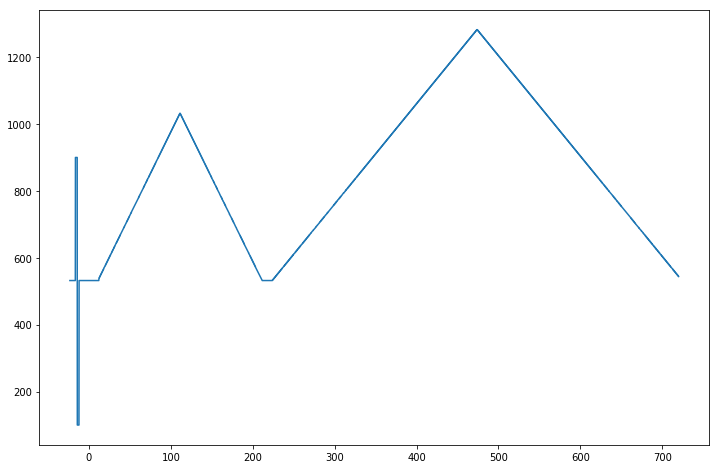

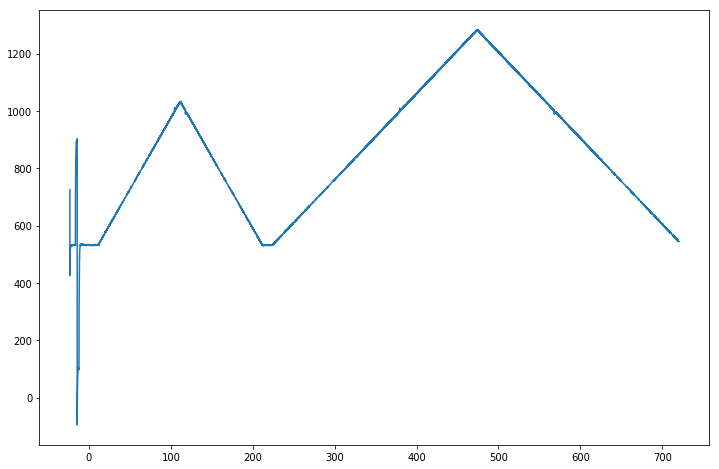

In [343]:
mask = frequencies[:,0] < 720

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequencies[:,0][mask],frequencies[:,1][mask])

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequencies[:,0][mask],frequencies[:,2][mask])

frequencies = frequencies[mask]

In [344]:
rate = 1/2
frequency_values = []
for idx in yag_fire:
    frequency_values.append((int(idx), frequencies[:,2][find_nearest_idx(frequencies[:,0], idx*rate-1.5)]))
frequency_values = np.array(frequency_values)

frequency_amp = []
for idx_f in fits:
    if fits[idx_f][0] < 0:
        frequency_amp.append((dict(frequency_values)[idx_f], np.abs(fits[idx_f][0]), idx_f))
frequency_amp = np.array(frequency_amp)
frequency_amp_wavemeter_cal = frequency_amp.copy()
frequency_amp_wavemeter_cal[:,0] += wavelength_values[0,1]*1e3-frequency_amp[0,0]

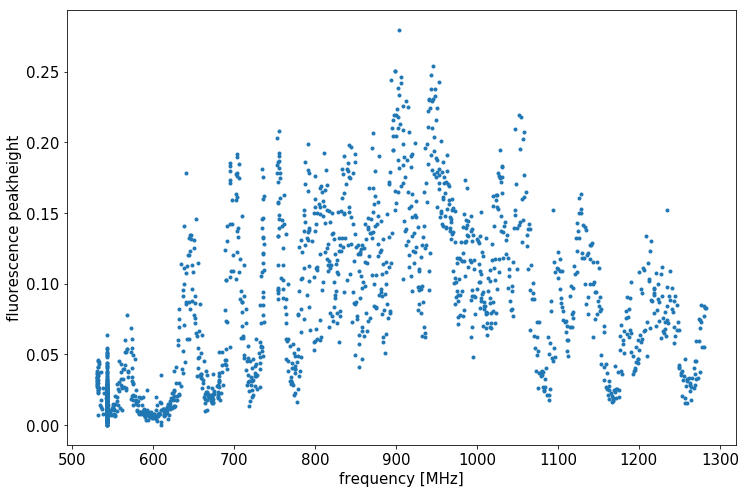

In [345]:
conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_amp[:,0]*conversion, frequency_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

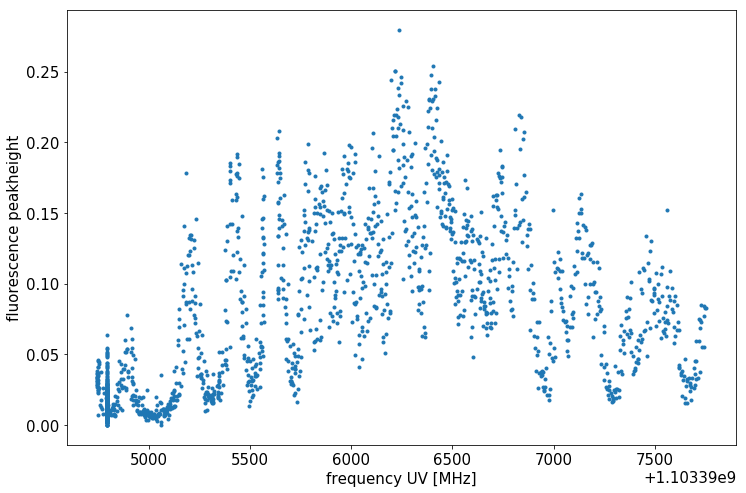

In [348]:
conversion = 4
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_amp_wavemeter_cal[:,0]*conversion, frequency_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency UV [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);
fig.savefig('scanning.png')